In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [ ]:
## Loading the dataset
X_test = np.load("/content/drive/MyDrive/project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
# print('Shape of training labels after categorical conversion:',y_train.shape)
# print('Shape of validation labels after categorical conversion:',y_valid.shape)
# print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
# print('Shape of training set after adding width info:',x_train.shape)
# print('Shape of validation set after adding width info:',x_valid.shape)
# print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)




Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)


In [ ]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=16, kernel_size=(9,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=32, kernel_size=(9,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=32, kernel_size=(9,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))


# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((32))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((32,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.1, return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 16)        3184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 16)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 16)        64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 32)         4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 32)        0

In [ ]:
# Model parameters
learning_rate = 0.001
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/100


2023-03-19 23:30:51.341212: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


109/109 [==============================] - 4s 27ms/step - loss: 1.3698 - accuracy: 0.3023 - val_loss: 1.3297 - val_accuracy: 0.3580
Epoch 2/100
109/109 [==============================] - 3s 25ms/step - loss: 1.2847 - accuracy: 0.3876 - val_loss: 1.2329 - val_accuracy: 0.4387
Epoch 3/100
109/109 [==============================] - 3s 24ms/step - loss: 1.2217 - accuracy: 0.4315 - val_loss: 1.2034 - val_accuracy: 0.4660
Epoch 4/100
109/109 [==============================] - 3s 24ms/step - loss: 1.1755 - accuracy: 0.4635 - val_loss: 1.1979 - val_accuracy: 0.4620
Epoch 5/100
109/109 [==============================] - 3s 24ms/step - loss: 1.1522 - accuracy: 0.4773 - val_loss: 1.1541 - val_accuracy: 0.4647
Epoch 6/100
109/109 [==============================] - 3s 26ms/step - loss: 1.1208 - accuracy: 0.5009 - val_loss: 1.1464 - val_accuracy: 0.4960
Epoch 7/100
109/109 [==============================] - 3s 25ms/step - loss: 1.1009 - accuracy: 0.5125 - val_loss: 1.1580 - val_accuracy: 0.4773
Epoc

In [ ]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7200902700424194


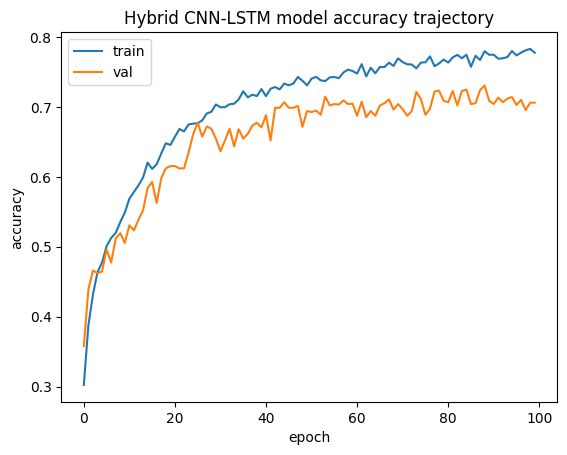

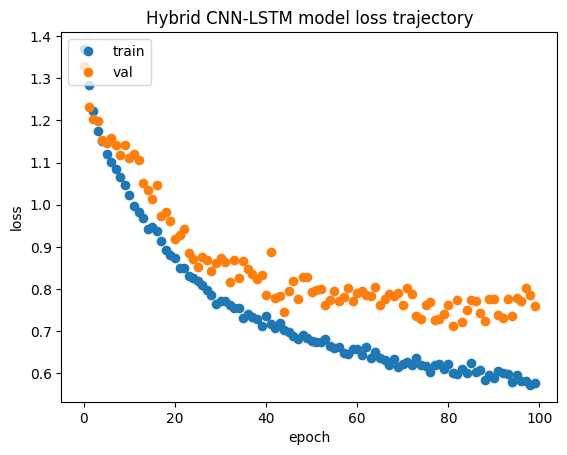

In [ ]:
# Plotting accuracy trajectory
plt.figure()
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('acc.png')

# Plotting loss trajectory
plt.figure()
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')


In [ ]:
hybrid_cnn_lstm_model.save('../best_cnnlstm.h5')